In [1]:
# Imports
from sklearn.tree import DecisionTreeClassifier
from lib.utils import load_raw,load_psd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn.functional import relu,one_hot
from tqdm import tqdm

/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()
raw = load_raw(2)
df = load_psd(2)

In [3]:
eeg = raw.get_data(picks='EEG')[0]

In [4]:
X = eeg.reshape(-1,5000)
y = np.array(pd.Categorical(df['label']).codes)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).reshape(-1,1).long()

In [5]:
s_idx = np.where(y==1)[0]
w_idx = np.where(y==2)[0]
idx = np.concatenate([s_idx,w_idx])
X = X[idx]
y = y[idx]-1

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.5,shuffle=True,stratify=y)

In [7]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.d1 = nn.Linear(5000,10000)
        self.r1 = nn.ReLU()
        self.d2 = nn.Linear(10000,2)

    def forward(self,x):
        x = self.d1(x)
        x = self.r1(x)
        x = self.d2(x)
        return x
model = MLP().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [9]:
model(X_train[0].cuda()).shape

torch.Size([2])

In [10]:
y_train_one_hot = one_hot(y_train,num_classes=2).reshape(-1,2).float()
y_test_one_hot = one_hot(y_test,num_classes=2).reshape(-1,2).float()

In [11]:
train_losses= []
test_losses = []

In [12]:
from torch.utils.data import TensorDataset
training_data = TensorDataset(X_train,y_train_one_hot)
testing_data = TensorDataset(X_test,y_test_one_hot)
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=256, shuffle=True)

In [13]:
device = 'cuda'

In [16]:
for epoch in range(10):
    training_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    training_loss = training_loss/len(train_dataloader)
    train_losses.append(training_loss)
    test_loss = 0
    for (X,y) in test_dataloader:
        X = X.cuda()
        y = y.cuda()
        logits = model(X)
        loss = criterion(logits,y)
        test_loss += loss.item()
    test_loss = test_loss/len(test_dataloader)
    test_losses.append(test_loss)
    print(f'Epoch {epoch} Train Loss : {training_loss} Test Loss : {test_loss}')

Epoch 0 Train Loss : 0.686728410422802 Test Loss : 0.6925106756389141
Epoch 1 Train Loss : 0.6822658218443394 Test Loss : 0.6908823102712631
Epoch 2 Train Loss : 0.6807375103235245 Test Loss : 0.6931292898952961
Epoch 3 Train Loss : 0.6790055111050606 Test Loss : 0.6994638554751873
Epoch 4 Train Loss : 0.6779632940888405 Test Loss : 0.6978677324950695
Epoch 5 Train Loss : 0.6726086251437664 Test Loss : 0.6919027976691723
Epoch 6 Train Loss : 0.6665628626942635 Test Loss : 0.6937275156378746
Epoch 7 Train Loss : 0.6636030077934265 Test Loss : 0.6951894164085388
Epoch 8 Train Loss : 0.6682896092534065 Test Loss : 0.6943117417395115
Epoch 9 Train Loss : 0.6642088331282139 Test Loss : 0.6960193365812302


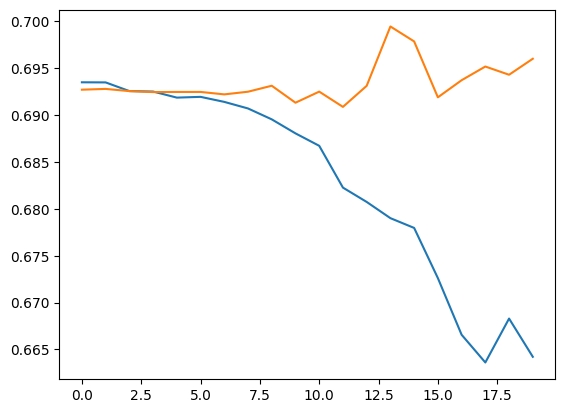

: 

In [19]:
plt.plot(train_losses)
plt.plot(test_losses)

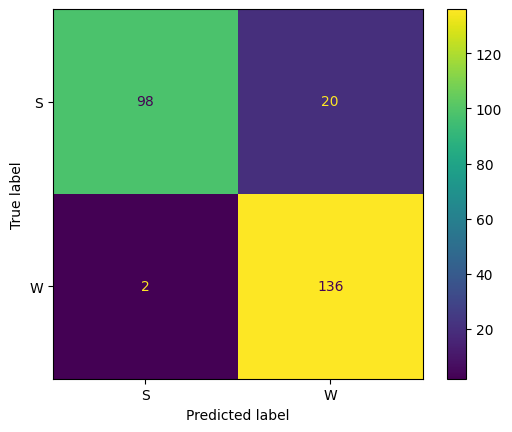

In [59]:
X,y = next(iter(train_dataloader))
X,y = X.to(device), y.to(device)
y_pred_logits = model(X.cuda())
sm = nn.Softmax(dim=1)
y_pred = sm(y_pred_logits).argmax(axis=1).cpu()
y = y.argmax(axis=1).cpu()
cm = ConfusionMatrixDisplay(confusion_matrix(y,y_pred),display_labels=['S','W'])
cm.plot()

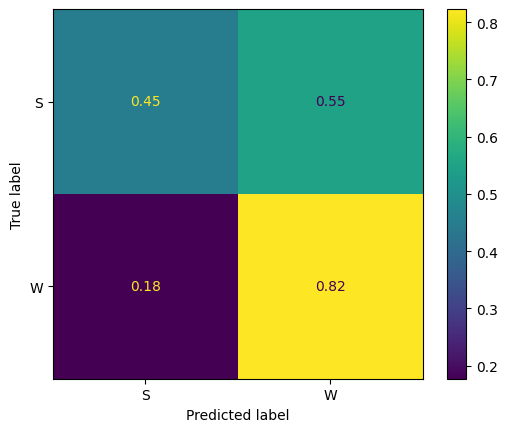

: 

In [61]:
y_pred_logits = model(X_test.cuda())
sm = nn.Softmax(dim=1)
y_pred = sm(y_pred_logits).argmax(axis=1)
cm = ConfusionMatrixDisplay(confusion_matrix(y_test.squeeze(),y_pred.cpu(),normalize='true'),display_labels=['S','W'])
cm.plot()